In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__name__))))
sys.path.insert(0, SOURCE_DIR)

In [3]:
SOURCE_DIR

'/home/husein/dev/malaya-speech'

In [4]:
import malaya_speech
from malaya_speech import Pipeline
from malaya_speech.utils.astype import float_to_int
malaya_speech

`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


<module 'malaya_speech' from '/home/husein/dev/malaya-speech/malaya_speech/__init__.py'>

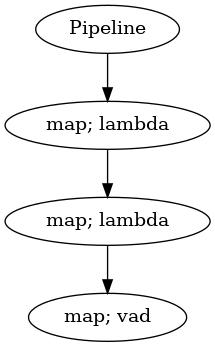

In [5]:
vad_model = malaya_speech.vad.webrtc()
p_vad = Pipeline()
pipeline = (
    p_vad.map(lambda x: malaya_speech.resample(x, old_samplerate = 22050, new_samplerate = 16000))
    .map(lambda x: float_to_int(x, divide_max_abs=False))
    .map(vad_model)
)
p_vad.visualize()

In [7]:
from glob import glob

youtubes = sorted(glob('/home/husein/youtube/audio/*.mp3'))
youtubes = youtubes[: len(youtubes) // 2]
len(youtubes)

2785

In [8]:
model = malaya_speech.stt.transducer.pt_transformer(model = 'mesolitica/conformer-medium')

In [9]:
_ = model.cuda()
_ = model.eval()

In [10]:
model_mixed_augmented = malaya_speech.stt.transducer.pt_transformer(model = 'mesolitica/conformer-medium-mixed-augmented')

In [11]:
_ = model_mixed_augmented.cuda()
_ = model_mixed_augmented.eval()

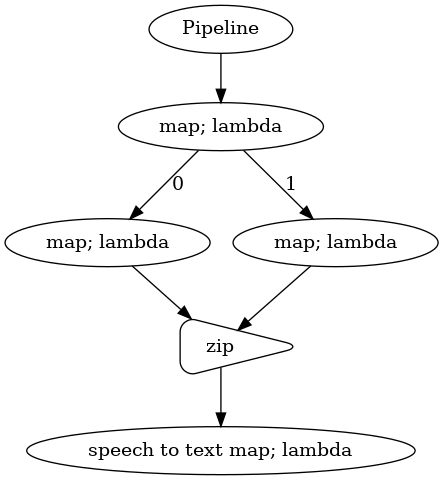

In [12]:
p_asr = Pipeline()
resample = p_asr.map(lambda x: malaya_speech.resample(x, old_samplerate = 22050, new_samplerate = 16000))
p = resample.map(lambda x: model([x])[0][0])
p2 = resample.map(lambda x: model_mixed_augmented([x])[0][0])
p.zip(p2).map(lambda x: x, name = 'speech-to-text')
p_asr.visualize()

In [13]:
y = malaya_speech.load('/home/husein/dev/malaya-speech/speech/example-speaker/husein-zolkepli.wav', sr = 22050)[0]

In [14]:
p_asr(y)['speech-to-text']

(('testing nama saya husin bin zulkifli',
  [0.1963536524603048],
  [127, 337, 185, 232, 31, 432, 40, 34, 306, 602, 204, 178, 124, 51]),
 ('testing nama saya hussein bin zulkifli',
  [0.32562975725359145],
  [127, 337, 185, 232, 31, 432, 17, 192, 67, 306, 602, 204, 178, 124, 51]))

In [15]:
from unidecode import unidecode
import torchaudio
import torch
import pickle

In [16]:
parent_dir = '/home/husein/ssd2/processed-youtube-asr-v2'
# !rm -rf {parent_dir}
!mkdir {parent_dir}

mkdir: cannot create directory ‘/home/husein/ssd2/processed-youtube-asr-v2’: File exists


In [17]:
parent_dir_done = '/home/husein/ssd2/processed-youtube-asr-v2-done'
# !rm -rf {parent_dir_done}
!mkdir {parent_dir_done}

mkdir: cannot create directory ‘/home/husein/ssd2/processed-youtube-asr-v2-done’: File exists


In [18]:
from tqdm import tqdm

In [ ]:
for f in tqdm(youtubes):
    
    new_f = unidecode(os.path.split(f)[1].replace('.mp3', '').replace(' ', '_'))
    f_done = os.path.join(parent_dir_done, new_f)
    
    if os.path.exists(f_done):
        continue
    
    speakers = {}
    samples = malaya_speech.streaming.torchaudio.stream(f,
                                                        vad_model = p_vad,
                                                        asr_model = p_asr,
                                                        segment_length = 441,
                                                        realtime_print = False,
                                                        sample_rate = 22050,
                                                        min_length = 1.0,
                                                        max_length = 15.0)
    
    if len(samples):
        
        parent_new_f = os.path.join(parent_dir, new_f)
        os.makedirs(parent_new_f, exist_ok=True)

        for i in range(len(samples)):
            audio_path = os.path.join(parent_new_f, f'{i}.mp3')
            torchaudio.save(audio_path, 
                            torch.tensor(samples[i]['wav_data'].astype('float32')).unsqueeze(0), 
                            22050, format='mp3')
            samples[i]['wav_data'] = audio_path

        with open(f'{parent_new_f}.pkl', 'wb') as fopen:
            pickle.dump(samples, fopen)
            
    with open(f_done, 'w') as fopen:
        fopen.write('done')

 60%|█████████████████████████████████████████████████████▌                                   | 1676/2785 [15:50:23<65:26:56, 212.46s/it]

In [ ]:
samples[2]

In [ ]:
from datasets import Audio

reader = Audio(sampling_rate = 22050)

In [ ]:
audio = reader.decode_example(reader.encode_example(samples[-1]['wav_data']))['array']
processed = p_postprocessing(audio)['postprocessing']

In [ ]:
import IPython.display as ipd
ipd.Audio(audio, rate = 22050)

In [ ]:
ipd.Audio(processed, rate = 22050)